In [1]:
from keras.datasets import mnist, cifar100
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import (
    UpSampling2D,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    AveragePooling2D,
)
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import load_model
import keras
import tensorflow as tf
import keras.backend as K
import keras.backend.tensorflow_backend as KTF

import shutil, os, sys, io, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/pggan/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from layer_visualizer import LayerVisualizer

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

In [2]:
class GAN:
    def __init__(self):
        # ---------------------
        #  for log on TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Parameter
        # ---------------------
        self.resume = 0
        
        self.n_critic = 5
        self.λ = 10
        
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noiseの次元
        optimizer_disc = Adam(lr=0.0005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        optimizer_gen = Adam(lr=0.0005, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)

        # ---------------------
        #  Build model
        # ---------------------
        if self.resume == 0:
            self.discriminator = self.build_discriminator()
            self.generator = self.build_generator()
        else:
            self.discriminator = load_model('./saved_model/wgangp64_disc_model_'+str(self.resume)+'epoch.h5')
            self.generator = load_model('./saved_model/wgangp64_gen_model_'+str(self.resume)+'epoch.h5')

        # ---------------------
        #  Load pretrained weights
        # ---------------------
        pre_gen = load_model('./saved_model/wgangp32_gen_model_8000epoch.h5')
        for i, layer in enumerate(self.generator.layers[1].layers):
            if i in [1, 3, 5, 7]:  # Pretrained weight cannot be set at the 9th layer.
                layer.set_weights(pre_gen.layers[1].layers[i].get_weights())
                layer.trainable = False
        print('Genarator Summary:')
        self.generator.summary()

        pre_disc = load_model('./saved_model/wgangp32_disc_model_8000epoch.h5')
        for i, layer in enumerate(self.discriminator.layers[1].layers):
            j = i - len(self.discriminator.layers[1].layers)
            if j in [-8, -6, -4, -2]:  # Pretrained weight cannot be set at the -10th layer.
                layer.set_weights(pre_disc.layers[1].layers[j].get_weights())
                layer.trainable = False
        print('Discriminator Summary:')
        self.discriminator.summary()
        
        # https://github.com/tjwei/GANotebooks/blob/master/wgan-keras.ipynb
        # https://keras.io/ja/backend/#function
        img = Input(shape=self.img_shape)
        noise = Input(shape=(self.latent_dim,))
        gen_img = self.generator(noise)

        ϵ_input = K.placeholder(shape=(None,1,1,1))
        mixed_img = Input(shape=self.img_shape, tensor=ϵ_input * img + (1-ϵ_input) * gen_img)
        
        loss_real = K.mean(self.discriminator(img))
        loss_fake = K.mean(self.discriminator(gen_img))

        grad_mixed = K.gradients(self.discriminator(mixed_img), [mixed_img])[0]
        norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
        grad_penalty = K.mean(K.square(norm_grad_mixed -1))        
        
        loss = loss_fake - loss_real + self.λ * grad_penalty
        training_updates = optimizer_disc.get_updates(self.discriminator.trainable_weights, [], loss)
        self.discriminator_train = K.function([img, noise, ϵ_input], [loss], training_updates)

        loss = -loss_fake
        training_updates = optimizer_gen.get_updates(self.generator.trainable_weights, [], loss)
        self.generator_train = K.function([noise], [loss], training_updates)
        
    def build_generator(self):
        model = Sequential()
        model.add(Reshape((self.input_rows, self.input_cols, int(self.latent_dim / (self.input_rows * self.input_cols))), 
                          input_shape=(self.latent_dim,)
                         ))
        
        model.add(Conv2DTranspose(512, (3, 3), strides=1, padding='same',
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))      
        
        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2DTranspose(512, (3, 3), strides=2, padding='same', 
                                     kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                     ))
            model.add(LeakyReLU(alpha=0.2))
              
        model.add(Conv2DTranspose(256, (3, 3), strides=1, padding='same', 
                                  kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                  ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(32, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(16, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, (3, 3), strides=1, padding='same', 
                                 kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                                 ))                
        model.add(Activation("tanh"))
        
        # print('Generator Summary:')
        # model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(16, (1, 1), strides=1, input_shape=self.img_shape, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(32, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(64, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(128, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(256, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2D(512, (3, 3), strides=1, padding="same",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(LeakyReLU(alpha=0.2))
        
        for _ in range(int(math.log(self.img_rows / self.input_rows, 2))):
            model.add(Conv2D(512, (3, 3), strides=2, padding="same",
                             kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                            ))
            model.add(LeakyReLU(alpha=0.2))
      
        model.add(Conv2D(1, (4, 4), strides=1, padding="valid",
                         kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        ))
        model.add(Flatten())
        
        # print('Discriminator Summary:')
        # model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        # ---------------------
        #  Load the dataset
        # ---------------------      
        # Original dataset
        X_train = np.load('../datasets/lfw64.npz')['arr_0']
        X_train = X_train / 127.5 - 1.0   # Rescale -1 to 1
        epsilon = np.random.uniform(size = (batch_size, 1,1,1))
        
        for epoch in tqdm(range(self.resume, epochs + 1)):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            for _ in range(self.n_critic):
                # Generate a batch of new images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                # Generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                d_loss, = self.discriminator_train([imgs, noise, epsilon])

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss, = self.generator_train([noise])

            # ---------------------
            #  Log on TensorBoard
            # ---------------------
            # Backup Model
            if epoch != 0 and epoch % 1000 == 0:
                self.discriminator.save('./saved_model/wgangp64_disc_model_'+str(epoch+self.resume)+'epoch.h5')
                self.generator.save('./saved_model/wgangp64_gen_model_'+str(epoch+self.resume)+'epoch.h5')
            
            # Save Loss & Histgram
            logs = {
                "Discriminator/loss": d_loss,
                "Generator/loss": g_loss,
            }
            histograms = {}
            for layer in self.discriminator.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            self.logger.log(logs=logs, histograms=histograms, epoch=epoch+self.resume)
 
            # Save generated image samples
            if epoch+self.resume == 1000 or epoch+self.resume == 2000 or (epoch+self.resume) % sample_interval == 0:
                fig, name = self.sample_images(epoch+self.resume)
                images = {name: fig}
                self.logger.log(images=images, epoch=epoch+self.resume)
                print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, :self.channels], cmap="gray")
                axs[i, j].axis("off")
                cnt += 1
        name = str(epoch) + ".png"
        return fig, name

In [3]:
gan = GAN()

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 64, 64, 3)         11048867  
Total params: 11,048,867
Trainable params: 3,932,067
Non-trainable params: 7,116,800
_________________________________________________________________
Discriminator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 11019809  
Total params: 11,019,809
Trainable params: 3,932,192
Non-trainable params: 7,087,617
______________________________________________________________

  0%|          | 1/10001 [00:34<94:47:08, 34.12s/it]

0 [D loss: -75.454239] [G loss: 157.943375]


 10%|█         | 1001/10001 [2:16:58<21:11:33,  8.48s/it]

1000 [D loss: -4.157713] [G loss: -14.261378]


 10%|█         | 1023/10001 [2:20:13<21:05:50,  8.46s/it]

KeyboardInterrupt: 

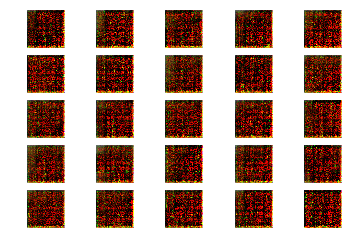

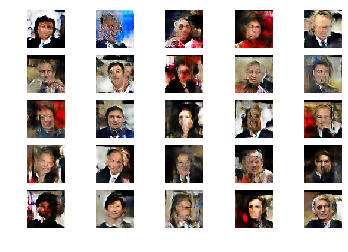

In [4]:
gan.train(epochs=10000, batch_size=32, sample_interval=5000)

In [6]:
gan.generator.save('./saved_model/wgangp64_gen_model.h5')
gan.discriminator.save('./saved_model/wgangp64_disc_model.h5')

In [ ]:
noise = np.random.normal(0, 1, (32, 128))
gen_imgs = gan.generator.predict(noise)
gen_imgs = (0.5 * gen_imgs[random.randint(0, 31)] + 0.5) * 255
gen_imgs = gen_imgs.astype('uint8')
img = Image.fromarray(gen_imgs)
img

In [34]:
import datetime
date = datetime.datetime.today().strftime("%Y%m%d_%H%M%S")
img.save("./images/"+ date +".png")

In [14]:
pre_disc = load_model('./saved_model/wgangp32_disc_model_7000epoch.h5')

In [30]:
print("Now")
for i, layer in enumerate(gan.discriminator.layers[1].layers):
    j = i - len(gan.discriminator.layers[1].layers)
    print(j, layer.name)
gan.discriminator.layers[1].summary()

print("Pre")
model = pre_disc.layers[1]
for i, layer in enumerate(pre_disc.layers[1].layers):
    j = i - len(pre_disc.layers[1].layers)
    print(j, layer.name)
model.summary()

Now
-22 conv2d_46
-21 leaky_re_lu_73
-20 conv2d_47
-19 leaky_re_lu_74
-18 conv2d_48
-17 leaky_re_lu_75
-16 conv2d_49
-15 leaky_re_lu_76
-14 conv2d_50
-13 leaky_re_lu_77
-12 conv2d_51
-11 leaky_re_lu_78
-10 conv2d_52
-9 leaky_re_lu_79
-8 conv2d_53
-7 leaky_re_lu_80
-6 conv2d_54
-5 leaky_re_lu_81
-4 conv2d_55
-3 leaky_re_lu_82
-2 conv2d_56
-1 flatten_4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_73 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 64, 64, 32)        0         
_____________________________________________________